# ACSE-3 (Numerical Methods) <a class="tocSkip">

## Coursework<a class="tocSkip">

# Instructions  <a class="tocSkip">
    

- This is the assessed coursework for module ACSE-3: Numerical Methods for year 2019/20.


- This is independent work, you cannot work in groups.


- Each question below is equally weighted in terms of marks.


- You will be assessed on both your code as well as your supporting descriptions/discussions of the results you obtain.


- You may use NumPy and SciPy. If you use an algorithm (e.g. from SciPy) not explicitly mentioned in the question, then please explain which algorithm you are using and why you have chosen it.


- You should submit your solutions as a single self-contained Jupyter notebooks via Github classroom - please submit a version where you have run all of the cells and all the outputs/plots etc are visible without me having to run the notebook myself.


<br><br>

# DEADLINE:   5pm Sunday 5 Jan 2020 <a class="tocSkip">

<br><br>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Coursework-Q1---Implement-RK2-family" data-toc-modified-id="Coursework-Q1---Implement-RK2-family-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Coursework Q1 - Implement RK2 family</a></span></li><li><span><a href="#Coursework-Q2---Implementing-backward-Euler-using-a-nonlinear-system-solver" data-toc-modified-id="Coursework-Q2---Implementing-backward-Euler-using-a-nonlinear-system-solver-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Coursework Q2 - Implementing backward Euler using a nonlinear system solver</a></span></li><li><span><a href="#Coursework-Q3---Steady-state-advection-diffusion-with-the-FEM" data-toc-modified-id="Coursework-Q3---Steady-state-advection-diffusion-with-the-FEM-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Coursework Q3 - Steady-state advection-diffusion with the FEM</a></span></li><li><span><a href="#Coursework-Q4---Time-dependent-advection-diffusion-with-the-FEM" data-toc-modified-id="Coursework-Q4---Time-dependent-advection-diffusion-with-the-FEM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Coursework Q4 - Time-dependent advection-diffusion with the FEM</a></span></li></ul></div>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# as we're in 2D we will be doing some 3D plotting
from mpl_toolkits.mplot3d import Axes3D
# and using some colormaps
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

# font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

# Coursework Q1 - Implement RK2 family

Write a function that implements the RK2 family of methods which takes in the free parameter $\alpha$ that appears in the most general definition of RK2.

For example the first line of your function might read

```Python
def RK2_alpha(f, y0, t0, t_max, dt, alpha=0.5):
```

where `f` is a function of time and the solution $y$.

<br>

Perform some verification tests of your function to confirm that with the choice $\alpha=1$ your implementation agrees with results from the improved Euler method which was implemented in lecture 5. 

<br>

Test for convergence using several different values of $\alpha$ using the test problem with RHS and exact solutions given by the test case we saw in lecture 6:

$$ y' = y + t^3, \;\;\;\;\;\; y(0) = 1, $$  

which has the exact solution

$$ y(t) = 7\text{e}^t - t^3 - 3t^2 - 6t - 6. $$

You may make use of the following functions implementing these:

```python
def f(t, y):
    return y + t**3

def y_ex(t):
    return 7*np.exp(t) - t**3 - 3*t**2 - 6*t - 6
```

<br>

Consider a simple error metric given by the error in the solution at time $t=3$.

<br>

Plot your convergence results, compared with results from the forward Euler and the improved Euler methods, and add to the graph your estimates for the order of convergence of each method.

<br>

Also, for a fixed time step size, compute and plot how the error varies as a function of $\alpha$ for values in the range $[0.1,4.0]$.  

<br>

What is the optimal value of $\alpha$ which minimises the error for this problem?

In [2]:
def f(t, y):
    return y + t**3

def y_ex(t):
    return 7*np.exp(t) - t**3 - 3*t**2 - 6*t - 6

In [3]:
def forward_euler(f, u0, t0, t_max, dt):
    """ Forward Euler time-stepper.
    f = f(t,y) is the RHS function.
    u0 is the initial condition.
    t0 is the initial time; t_max is the end time.
    dt is the time step size.
    """ 
    u = np.array(u0)
    t = np.array(t0)
    u_all = [u0]
    t_all = [t0]
    while t < t_max:
        u = u + dt*f(t, u)  # euler guess
        u_all.append(u)
        t = t + dt
        t_all.append(t)
    return np.array(u_all), np.array(t_all)

def improved_euler(f, u0, t0, t_max, dt):
    u = np.array(u0)
    t = np.array(t0)
    u_all = [u0]
    t_all = [t0]
    while t < t_max:
        ue = u + dt*f(t, u)  # euler guess
        u = u + 0.5*dt* ( f(t, u) + f(t + dt, ue) )
        u_all.append(u)
        t = t + dt
        t_all.append(t)
    return np.array(u_all), np.array(t_all)


def f_msd(t, u):
    """ RHS function for mass-spring-damper problem.
    
    u for MSD is the vector [x, v]
    """
    f = np.zeros_like(u)
    f[0] = u[1]
    f[1] = -2.*zeta*om0*u[1] - om0**2 * u[0]
# NB. could write this as A*u with
# A = np.matrix([[0, 1], [-om0**2, -2*zeta*om0]])
    return f

In [4]:
def RK2_alpha(f, y0, t0, t_max, dt, alpha=0.5):
    """
     f: input function of t and solution of y
    """
    
    u = np.array(u0) #array intialized to hold mesh points t
    tau = np.array(t0) #array to hold Midpoint
    u_all = [u0]
    tau_all = [t0]  #intial condition
    
    #iterative method
    while tau < t_max:
        k1 = f(tau, u)
        # next iteration using midpoint method 
        u = u + dt * ( (1-1/(2*alpha))*k1 + 1/(2*alpha)* f(tau + alpha*dt, u + alpha*dt*k1 ))
        u_all.append(u)
        tau = tau + dt
        tau_all.append(tau)
    
    return np.array(tau_all), np.array(u_all)


Perform some verification tests of your function to confirm that with the choice 𝛼=1 
your implementation agrees with results from the improved Euler method which was implemented in lecture 5.

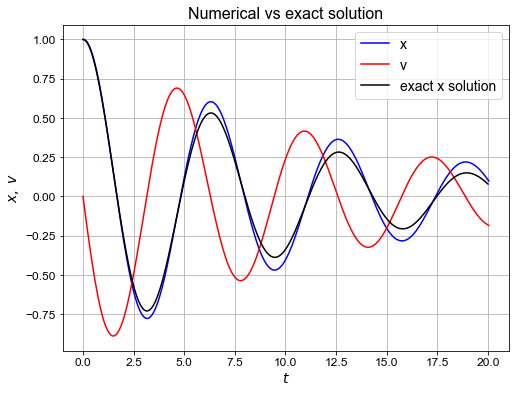

In [5]:
# Let's 
# numerical parameters for problem
om0 = 1
zeta = 0.1
# initial data (we need two for this coupled problem)
x0 = 1
v0 = 0
# simulation period and time step size
t0 = 0.
tf = 20.
dt = 0.04

# initial condition
u0 = np.array([x0, v0])
uall, tall = forward_euler(f_msd, u0, t0, tf, dt)

# pull out the individual solution vectors (don't need to do this)
x = uall[:, 0]
v = uall[:, 1]

fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(111)
ax1.plot(tall, x, 'b', label='x')
ax1.plot(tall, v, 'r', label='v')
ax1.set_xlabel(r'$t$', fontsize=14)
ax1.set_ylabel(r'$x,\; v$', fontsize=14)
ax1.set_title('Numerical vs exact solution', fontsize=16)
ax1.grid(True)

def x_exact(t):
    # the exact solution to the x component of the problem
    om = om0 * np.sqrt(1-zeta**2)
    x_exact = (np.exp(-zeta*om0*t)*(x0*np.cos(om*t) +
                                    (zeta*x0+v0/om0)*((om0/om)**2)*np.sin(om*t)))
    return x_exact

tfine = np.arange(0, tf, dt/100)
ax1.plot(tfine, x_exact(tfine), 'k', label='exact x solution')
# note we could easily compute and plot the exact v solution as well, we don't just so the plot doesn't get too "busy"
ax1.legend(loc='best', fontsize=14);

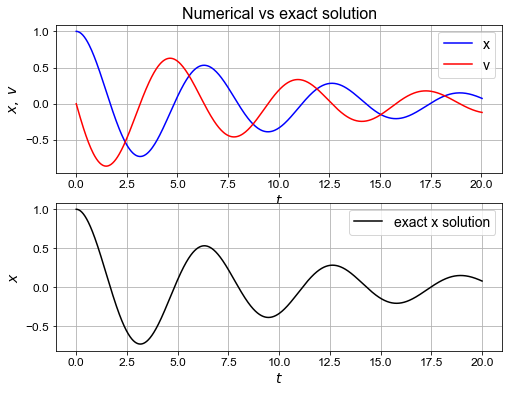

In [6]:
## RK2
tall,uall = RK2_alpha(f_msd, u0, t0, tf, dt, 1)

# pull out the individual solution vectors (don't need to do this)
x = uall[:,0]
v = uall[:,1]

fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(211)
ax1.plot(tall, x, 'b', label='x')
ax1.plot(tall, v, 'r', label='v')
ax1.set_xlabel(r'$t$', fontsize=14)
ax1.set_ylabel(r'$x,\; v$', fontsize=14)
ax1.set_title('Numerical vs exact solution', fontsize=16)
ax1.grid(True)
# note we could easily compute and plot the exact v solution as well, we don't just so the plot doesn't get too "busy"
ax1.legend(loc='best', fontsize=14);

ax2 = plt.subplot(212)
tfine = np.arange(0, tf, dt/100)
ax2.plot(tfine, x_exact(tfine), 'k', label='exact x solution')
ax2.set_xlabel(r'$t$', fontsize=14)
ax2.set_ylabel(r'$x$', fontsize=14)
ax2.grid(True)

# note we could easily compute and plot the exact v solution as well, we don't just so the plot doesn't get too "busy"
ax2.legend(loc='best', fontsize=14);

Test for convergence using several different values of 𝛼 using the test problem with RHS 
and exact solutions given by the test case we saw in lecture 6:
Consider a simple error metric given by the error in the solution at time 𝑡=3 
Plot your convergence results, compared with results from the forward Euler and the improved Euler methods, 
and add to the graph your estimates for the order of convergence of each method.

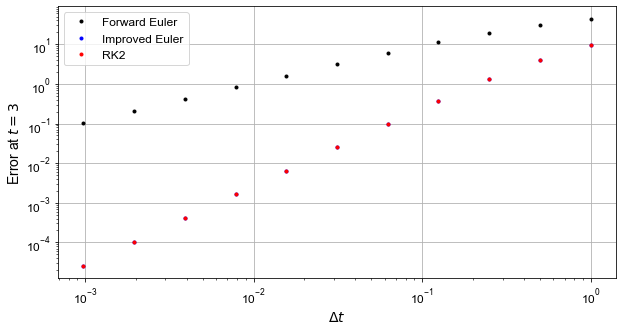

In [7]:

# problem parameters
dt = 0.04
u0 = 1.0
t0 = 0.0
tf = 2*np.pi

def approx_error(dt, t_max):
    uall, tall = forward_euler(f, u0, t0, t_max, dt)
    err1 = abs(uall[-1] - y_ex(t_max))
    uall, tall = improved_euler(f, u0, t0, t_max, dt)
    err2 = abs(uall[-1] - y_ex(t_max))
    tall,uall = RK2_alpha(f, u0, t0, t_max, dt, 1)
    err3 = abs(uall[-1] - y_ex(t_max))
    return err1, err2, err3

error_fe = []
error_ie = []
error_rk2 = []
dt_array = []
dt = 1.
while dt > 5.e-4:
    dt_array.append(dt)
    err1, err2, err3 = approx_error(dt, 3)
    error_fe.append(err1)
    error_ie.append(err2)
    error_rk2.append(err3)
    dt *= 0.5

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1.loglog(dt_array, error_fe, 'k.', label='Forward Euler')
ax1.loglog(dt_array, error_ie, 'b.', label='Improved Euler')
ax1.loglog(dt_array, error_rk2, 'r.', label='RK2')
ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('Error at $t=3$', fontsize=14)
ax1.grid(True)
ax1.legend()
# use numpy.polyfit to find best fit linear line to data

Also, for a fixed time step size, compute and plot how the error varies as a function of 𝛼　for values in the range [0.1,4.0] 
What is the optimal value of 𝛼, which minimises the error for this problem?

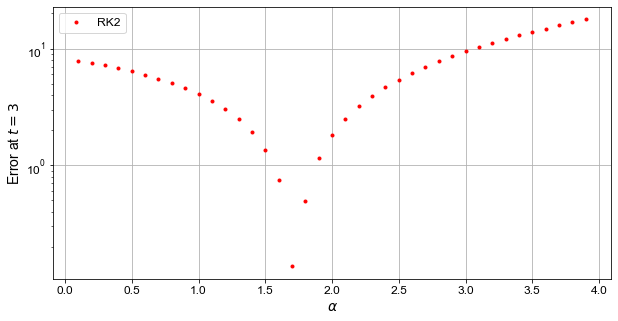

In [8]:
alphas = np.arange(0.1, 4, 0.1)
dt = 0.5 # fixed 
t_max = 3
error_rk2 = []
for alpha in alphas:
    tall,uall = RK2_alpha(f, u0, t0, t_max, dt, alpha)
    err3 = abs(uall[-1] - y_ex(t_max))
    error_rk2.append(err3)
    
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1.semilogy(alphas, error_rk2, 'r.', label='RK2')
ax1.set_xlabel('$\\alpha$', fontsize=14)
ax1.set_ylabel('Error at $t=3$', fontsize=14)
ax1.grid(True)
ax1.legend()

# Coursework Q2 - Implementing backward Euler using a nonlinear system solver

In the lecture 5 homework (question "circular orbits") we considered the vector ODE problem

\begin{align*}
\dot{x} & = -y, \\[5pt] 
\dot{y} & = x
\end{align*} 

with initial conditions $x(0)=1,\; y(0)=0$.  

We saw in that homework question how the forward and improved Euler methods performed on this problem.

Recall that the exact solution's trajectory in $(x,y)$ space should map out a circle, but forward Euler's orbit was found to rapidly increase in diameter.

<br> 

Write a function to implement the backward Euler scheme for a generic RHS vector function $\boldsymbol{f}$. 

To do this you will need to call a nonlinear system solver, make use of one of the ones that we saw in lecture 4.

<br>

Run your code for the above problem and comment on the qualitative differences between your solution obtained with backward Euler with that obtained using forward Euler.

<br>

Based on your observations implement another implicit two-level scheme which should provide qualitatively improved results compared with both forward and backward Euler. 

<br>

Given that the exact solution maps out a circle, consider what mathematical conservation law (a function of the solution variables that should be constant) the solution should respect and check how well each of your methods performs at satisfying this law.

Write a function to implement the backward Euler scheme for a generic RHS vector function 𝑓.

call a nonlinear system solver in $lecture 4$.

Run your code for the above problem and comment on the qualitative differences between solutions obtained with $backward Euler$ with that obtained using $forward Euler$.

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# scipy's optimization
import scipy.optimize as sop
import scipy.linalg as sl

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [10]:
def forward_euler(f, u0, t0, t_max, dt):
    """ Forward Euler time-stepper.
    f = f(t,y) is the RHS function.
    u0 is the initial condition.
    t0 is the initial time; t_max is the end time.
    dt is the time step size.
    """ 
    u = np.array(u0)
    t = np.array(t0)
    u_all = [u0]
    t_all = [t0]
    while t < t_max:
        u = u + dt*f(t, u)  # euler guess
        u_all.append(u)
        t = t + dt
        t_all.append(t)
    return np.array(u_all), np.array(t_all)

define problem and apply the forward Euler  

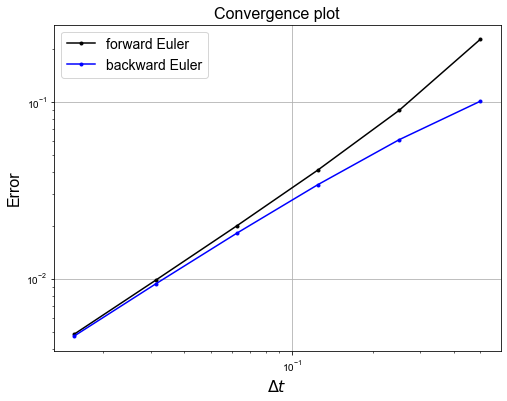

In [11]:
K = 2
C0 = 1
tend = 1


def f(t, C):
    return -K*C

def Cex(t):
    # this function evaluates the exact solution to the problem
    return C0*np.exp(-K*t)

# set up figure
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

# the range of time step sizes we will consider
dts = [0.5/(2**n) for n in range(0, 6)]

# somewhere to store our errors for each time step size
FE_error = np.empty(len(dts))
BE_error = np.empty(len(dts))
leapfrog_error = np.empty(len(dts))
trap_error = np.empty(len(dts))

# loop over our different time step sizes, compute solution and corresponding error
for (i, dt) in enumerate(dts):
    # our time levels for the numerical solution
    N_dt = int(round(tend/dt))
    t = dt * np.linspace(0, N_dt, N_dt + 1)

    # forward Euler
    C = np.empty(len(t))
    C[0] = C0
    for (n, t_n) in enumerate(t[:-1]):
        C[n+1] = C[n] + dt * f(t_n, C[n])

    FE_error[i] = np.linalg.norm(C - Cex(t))/np.sqrt(len(C))

    # backward Euler
    def back_f(y1, y0, t, dt, f):
        return y1 - dt*f(t+dt, y1) - y0
    
    C = np.empty(len(t))
    C[0] = C0
    for (n, t_n) in enumerate(t[:-1]):
        # need to use an implicit equation solver.
        C[n+1] = sop.newton(back_f, C[n], args=(C[n],t_n+dt, dt, f))
        
    BE_error[i] = np.linalg.norm(C - Cex(t))/np.sqrt(len(C))

axs.loglog(dts, FE_error, 'k.-', label='forward Euler')
axs.loglog(dts, BE_error, 'b.-', label='backward Euler')
axs.set_xlabel('$\Delta t$', fontsize=16)
axs.set_ylabel('Error', fontsize=16)
axs.set_title('Convergence plot', fontsize=16)
axs.grid(True)
axs.legend(loc='best', fontsize=14)

In [14]:
def back_euler(f, u0, t0, t_max, dt):
    """ Forward Euler time-stepper.
    f = f(t,y) is the RHS function.
    u0 is the initial condition.
    t0 is the initial time; t_max is the end time.
    dt is the time step size.
    """ 
    u = np.array(u0)
    t = np.array(t0)
    u_all = [u0]
    t_all = [t0]
    while t < t_max:
        t = t + dt
        t_all.append(t)      
     
        def back_f(y1, y0, t, dt, f):
            return y1 - dt*f(t+dt, y1) - y0
        
        u = sop.newton(back_f, u, args=(u,t, dt, f))
        u_all.append(u)
        
    return np.array(u_all), np.array(t_all)   

def improved_euler(f, u0, t0, t_max, dt):
    u = np.array(u0)
    t = np.array(t0)
    u_all = [u0]
    t_all = [t0]
    while t < t_max:
        ue = u + dt*f(t, u)  # euler guess
        u = u + 0.5*dt* ( f(t, u) + f(t + dt, ue) )
        u_all.append(u)
        t = t + dt
        t_all.append(t)
    return np.array(u_all), np.array(t_all)

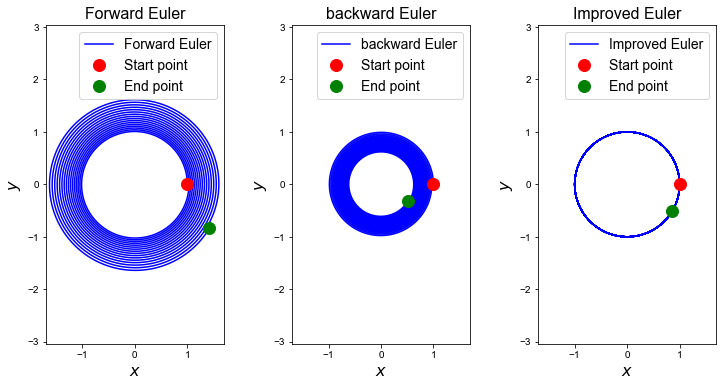

In [16]:
def f(t, u): 
    f = np.zeros_like(u)
    f[0] = -u[1]
    f[1] =  u[0]   
    return f

# problem parameters
dt = 0.01
u0 = np.array([1.,0.])
t0 = 0.0
tf = 100.

# set up figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
fig.tight_layout(w_pad=4)

u, t = forward_euler(f, u0, t0, tf, dt)
ax1.plot(u[:,0], u[:,1], 'b', label='Forward Euler')
ax1.plot(u[0,0], u[0,1], 'ro', label='Start point', markersize=12)
ax1.plot(u[-1,0], u[-1,1], 'go', label='End point', markersize=12)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Forward Euler', fontsize=16)
ax1.axis('equal')
ax1.legend(loc='best', fontsize=14)
ax1.set_xlim(-1.7,1.7)
ax1.set_ylim(-1.7,1.7)

u, t = back_euler(f, u0, t0, tf, dt)
ax2.plot(u[:,0], u[:,1], 'b', label='backward Euler')
ax2.plot(u[0,0], u[0,1], 'ro', label='Start point', markersize=12)
ax2.plot(u[-1,0], u[-1,1], 'go', label='End point', markersize=12)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
ax2.set_title('backward Euler', fontsize=16)
ax2.axis('equal')
ax2.legend(loc='best', fontsize=14)
ax2.set_xlim(-1.7,1.7)
ax2.set_ylim(-1.7,1.7)

u0 = np.array([1.,0.])
t0 = 0.0
u, t = improved_euler(f, u0, t0, tf, dt)
ax3.plot(u[:,0], u[:,1], 'b', label='Improved Euler')
ax3.plot(u[0,0], u[0,1], 'ro', label='Start point', markersize=12)
ax3.plot(u[-1,0], u[-1,1], 'go', label='End point', markersize=12)
ax3.set_xlabel('$x$', fontsize=16)
ax3.set_ylabel('$y$', fontsize=16)
ax3.set_title('Improved Euler', fontsize=16)
ax3.axis('equal')
ax3.legend(loc='best', fontsize=14)
ax3.set_xlim(-1.7,1.7)
ax3.set_ylim(-1.7,1.7);


# Coursework Q3 - Steady-state advection-diffusion with the FEM


In this part of the question we want to solve steady-state advection-diffusion using the (non-local-assembly based) finite element approach we developed in lecture 11.



Using the finite element method
formulate and solve the steady-state advection-diffusion (boundary value) problem with Dirichlet boundary conditions we considered in lecture 7 (the exact solution to which is given below).

The difference to what we've seen before in our FEM codes is that you now need to discretise the advection term, which ultimately involves integrating basis functions multiplied by their derivatives over elements.

[**Hint:** *your starting point for this might be the code we wrote in lecture 11 section 5.4 ("Dealing with more complex BCs (Inhomogeneous Dirichlet)"). You need to add in an extra contribution to the LHS corresponding to advection (cf. L11 homework 1.4 where we ended up adding a mass matrix when we solved the problem $u''+u=f$).  You will need to remember to also add in the appropriate extra advection related RHS terms corresponding to the boundary contributions (as was explained in the context of diffusion in section 5.4.2 of lecture 11).*]

<br>

Verify your implementation with a convergence with $\Delta x$ analysis using the exact solution given by
```Python
def u_exact(x):
    return CE * (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1)
```
You can use the following parameters (using the notation of lecture 7)
```Python
kappa = 0.005
L = 1
Pe = 10
U = Pe * kappa / L
CE = 1
```
where `CE` is the Dirichlet BC value at the right hand boundary, the left hand boundary being a homogeneous Dirichlet condition.



<br>

Do you observe the expected order of convergence?

<br>

Finally, compare the errors in your solution against a corresponding finite difference solver. You may re-use code from lecture 7 for this. What do you observe?

<br>

Throughout this question you may assume for simplicity a uniform mesh.

 lecture 11 section 5.4 ("Dealing with more complex BCs (Inhomogeneous Dirichlet)"). 

In [17]:
%precision 6
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as si
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# as we're in 2D we will be doing some 3D plotting
from mpl_toolkits.mplot3d import Axes3D
# and using some colormaps
from matplotlib import cm
from pprint import pprint

# some default font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

In [18]:
def hat_function(i, x_nodes):
    """ Top hat basis function at node i.
    Returns a function for later use in quadrature rules.
    """
    assert(i>=0 and i<=len(x_nodes)-1)
    dx = np.diff(x_nodes)
    if i==0:
        hat = lambda x: np.select([ x<=x_nodes[i+1] ], [ (x_nodes[i+1] - x)/dx[i] ] ,0.0)
    elif i==len(x_nodes)-1:
        hat = lambda x: np.select([ x>=x_nodes[i-1] ], [ (x - x_nodes[i-1])/dx[i-1] ] ,0.0)
    else:
        hat = lambda x: np.select(
                [ np.all([[x>=x_nodes[i-1]],[x<=x_nodes[i]]], axis=0)[0],  
                  np.all([[x>=x_nodes[i]],[x<=x_nodes[i+1]]], axis=0)[0]] ,
                [ (x-x_nodes[i-1])/dx[i-1], (x_nodes[i+1]-x)/dx[i] ] ,0.0)
    return hat

def mass_matrix(x):
    dx = np.diff(x)
    M = np.zeros((len(x), len(x)))
    M[1:-1,1:-1] = np.diag(dx[:-1]/3  +  dx[1:]/3 , k=0) 
    M += np.diag(dx/6   , k=-1) + np.diag(dx/6   , k=1)
    M[0,0] = dx[0]/3
    M[-1,-1] = dx[-1]/3
    return M

def simpsons_rule(a, b, function, number_intervals=10):
    
    interval_size = (b - a)/number_intervals

    assert interval_size > 0
    assert type(number_intervals) == int

    I_S = 0.0

    # Loop to valuate Simpson's formula over each interval 
    for i in range(number_intervals):
        # Find a, c, and b
        this_bin_start = a + interval_size * (i)
        this_bin_mid = this_bin_start + interval_size/2
        this_bin_end = this_bin_start + interval_size
        # Calculate the rule and add to running total.
        I_S += (interval_size/6) * (function(this_bin_start) +
                                  4 * function(this_bin_mid) + function(this_bin_end))

    # Return our running total result
    return I_S


error (RMS at nodes only) =  0.005077677177214887


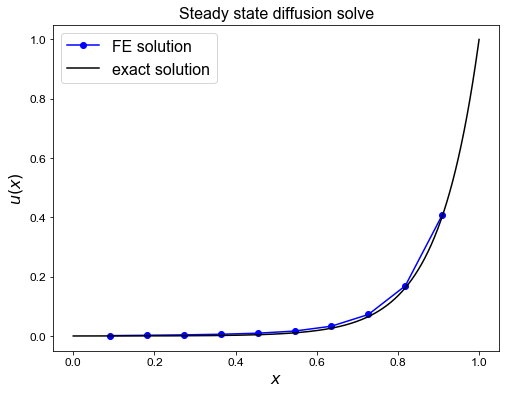

In [19]:

kappa = 0.005
L = 1
Pe = 10
U = Pe * kappa / L
CE = 1

uL = 0.
uR = CE

def f(x): # -u''
    return -CE/(np.exp(Pe)-1) * ( (Pe/L)**2 * np.exp(Pe*x/L)) 

def u_exact(x):
    return CE * (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1)

N_elements_CG = 11
N_nodes_CG = N_elements_CG + 1

x_nodes = np.linspace(0, 1 , N_nodes_CG )
dx = np.diff(x_nodes)
# space to store our discretisaton matrices
K = np.zeros((N_nodes_CG - 2, N_nodes_CG - 2))
RHS = np.zeros(N_nodes_CG - 2)

K = np.diag(1. / dx[:-1]  +  1. / dx[1:] , k=0) \
    - np.diag(1. / dx[1:-1]   , k=-1) \
    - np.diag(1. / dx[1:-1]   , k=1)

Mass = np.zeros((N_nodes_CG - 2, N_nodes_CG - 2))
# construct mass matrix
Mass_full = mass_matrix(x_nodes)
# we don't want the full mass matrix for this problem with Dirichlet conditions
# so just grab the internal bit
Mass = Mass_full[1:-1,1:-1]

# form RHS vector by integrating function f multiplied by basis function
# loop over internal nodes
for node in range(1, N_nodes_CG - 1):
    # and integrate our function multiplied by the corresponding cts basis function  
    phi_i = hat_function(node, x_nodes)
    integrand = lambda x : f(x) * phi_i(x)
    # simpsons with number intervals = 2 can integrate this exactly
    RHS[node-1] = simpsons_rule(x_nodes[node-1], x_nodes[node+1], integrand, 2)
    
RHS[0] = RHS[0] - (uL * 1/dx[0] * (-1/dx[0]))*dx[0]
# and similarly for the RHS
RHS[-1] = RHS[-1] - (uR * (-1/dx[-1]) * (1/dx[-1]))*dx[-1]

Disc = K - Mass
u = sl.solve(Disc, RHS)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u(x)$', fontsize=16)
ax1.set_title('Steady state diffusion solve', fontsize=16)
ax1.plot(x_nodes[1:-1], u, 'bo-', label='FE solution')
x_fine = np.linspace(0, 1, 1000)
ax1.plot(x_fine, u_exact(x_fine), 'k-', label='exact solution')
ax1.legend(loc='best', fontsize=16);

print('error (RMS at nodes only) = ', 
      sl.norm(u - u_exact(x_nodes[1:-1]) )
      /np.sqrt(len(u)) )

compare the errors in your solution against a corresponding finite difference solver. You may re-use code from lecture 7 for this. 

Uniform mesh (a = 1) gives an error of 0.162137
Minimum error of 0.032983 when a = 3.800000
my error (RMS at nodes only) =  0.005077677177214887


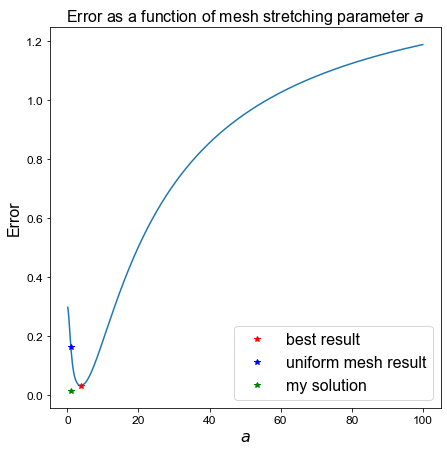

In [20]:

def BVP_AD_central_stretch_mesh(L, U, kappa, CE, N, Xfn):
    """ function to assemble and solve the AD BVP problem
    using central differences for both adv and diff
    with a mesh stretching given by the function Xfn
    """
    dxi = 1. / N
    xi = np.linspace(-dxi / 2, dxi / 2 + 1, N + 2)
    x = Xfn(xi)
    kappat = np.zeros_like(x)
    Ut = np.zeros_like(x) 
    for i in range(1, N + 1):
        Xxi = (x[i+1] - x[i-1]) / (2 * dxi)
        Xxixi = (x[i+1] - 2*x[i] + x[i-1]) / dxi**2
        Ut[i] = (1. / Xxi) * U + (Xxixi / (Xxi**3)) * kappa
        kappat[i] = (1. / Xxi**2) * kappa      
    A = np.zeros((N + 2, N + 2))
    b = np.zeros((N + 2))
    # interior points
    for i in range(1, N + 1):
        A[i, i - 1] = kappat[i] / (dxi**2) + 0.5 * Ut[i] / dxi
        A[i, i] = -2. * kappat[i] / dxi**2
        A[i, i + 1] = kappat[i] / (dxi**2) - 0.5 * Ut[i] / dxi
        b[i] = 0
    # BC1
    A[0, 0] = 0.5
    A[0, 1] = 0.5
    b[0] = 0
    # BC2
    A[N + 1, N] = 0.5
    A[N + 1, N + 1] = 0.5
    b[N + 1] = CE  
    # invert matrix
    C = np.linalg.solve(A, b)
    return x, C

# let's use a relatively small number of grid points
N = 8
# mesh stretching values to test
aa = np.linspace(0.1,100.,1000)
# define function to generate numerical solution
Xfn = lambda xi: L * np.arcsinh(np.sinh(a)*xi)/a
errors = np.zeros_like(aa)
for i, a in enumerate(aa):
    x, C = BVP_AD_central_stretch_mesh(L, U, kappa, CE, N, Xfn)
    errors[i] = np.linalg.norm(C - u_exact(x))

my_error = sl.norm(u - u_exact(x_nodes[1:-1]) )
    
a = 1.
x, C = BVP_AD_central_stretch_mesh(L, U, kappa, CE, N, Xfn)
uniform_error = np.linalg.norm(C - CE * (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1))
print('Uniform mesh (a = 1) gives an error of {0:.6f}'.format(uniform_error))
besti = np.argmin(errors)
print('Minimum error of {0:.6f} when a = {1:.6f}'.format(errors[besti], aa[besti]))
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
ax1.plot(aa,errors)
ax1.set_xlabel('$a$', fontsize=16)
ax1.set_ylabel('Error', fontsize=16)
ax1.set_title('Error as a function of mesh stretching parameter $a$', fontsize=16);
ax1.plot([aa[besti]], [errors[besti]], 'r*', label='best result')
ax1.plot([1.0], [uniform_error], 'b*', label='uniform mesh result')
ax1.plot([1.0], [my_error], 'g*', label='my solution')
ax1.legend(loc='best',fontsize=16);

print('my error (RMS at nodes only) = ', 
      sl.norm(u - u_exact(x_nodes[1:-1]) )
      /np.sqrt(len(u)) )

# Coursework Q4 - Time-dependent advection-diffusion with the FEM

In this part of the question we want to solve unsteady advection-diffusion.

This time base your solution on the 1D (local) assembly based finite element solver we implemented in lecture 12 and generalise it to include advection.

Test your implementation using the same advection-diffusion of a Gaussian problem considered in
lecture 8 homework question 2 "An analytical solution to advection-diffusion" where I explained and demonstrated how an appropriate Gaussian function can be considered as an exact solution to the advection-diffusion problem as long as we initialise our solution with the Gaussian evaluated at some $t>0$  (since in the limit of  $t=0$   the solution is a Dirac-delta function), and use that same offset in time for the purpose of comparing the analytical solution with the numerical solution you obtain.


```python
def adv_diff_analytical_solution(U, kappa, x0, x, t):
    """ Analtical solution to advection-diffusion for an assumed 
    Dirac-delta initial condition at t=0.
    """
    return np.exp( -((x-x0) - U*t)**2 / (4.*kappa*t)) / np.sqrt(4. * np.pi * kappa * t)
```


We can then use the same function evaluated at the appropriate time as an exact solution to compare our numerical method against.
For this question you can consider the (non-periodic) domain $x\in[0,3]$ and you can assume homogeneous Neumann boundary conditions. Initialise the problem using the analytical solution centred initially at $x=0.5$ with an initial time for the purposes of evaluating the Gaussian function of $t=0.05$. Assume a velocity of 1 and a diffusivity of 0.01. Integrate the problem for a total time period of 1 [NB. I've purposefully set these values and the size of the domain so you don't need to worry about your Gaussian getting close to a boundary].

Perform some experiments with different $\Delta x$ and $\Delta t$ values such that you can demonstrate the expected order of convergence in space and in time (for the time-stepping options of forward Euler, backward Euler and Crank-Nicolson). To do this I suggest you fix one of $\Delta x$ or $\Delta t$ and vary the other independently.

the same advection-diffusion of a Gaussian problem considered in lecture 8 homework question 2 "An analytical solution to advection-diffusion" where I explained and demonstrated how an appropriate Gaussian function can be considered as an exact solution to the advection-diffusion problem as long as we initialise our solution with the Gaussian evaluated at some 𝑡>0 (since in the limit of 𝑡=0 the solution is a Dirac-delta function), and use that same offset in time for the purpose of comparing the analytical solution with the numerical solution you obtain.

In [21]:
def adv_diff_analytical_solution(U, kappa, x0, x, t):
    """ Analtical solution to advection-diffusion for an assumed 
    Dirac-delta initial condition at t=0.
    """
    return np.exp( -((x-x0) - U*t)**2 / (4.*kappa*t)) / np.sqrt(4. * np.pi * kappa * t)

CFL:  0.10000
Pe_c: 10.00000
r:    0.01000


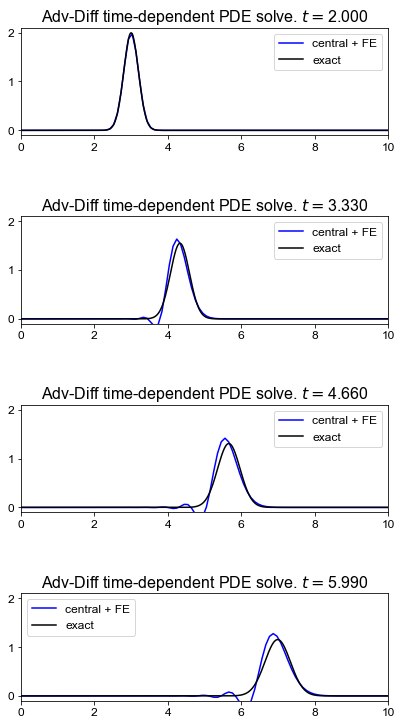

In [29]:
U = 1
kappa = 1./100.
N = 100
L = 10.
dx = L / N
dt = 0.01
t_start = 2.
t_end = t_start + 4.
x0 = 1.0

def adv_central_periodic(N):
    # advection - periodic
    Dx = 0.5*np.eye(N, k=1) - 0.5*np.eye(N, k=-1)
    # Add in the wrapped values due to periodicity
    Dx[0, -1] = -0.5
    Dx[-1, 0] = 0.5
    return Dx

def diff_central_periodic(N):
    # diffusion - periodic
    Dxx = np.eye(N, k=1) - 2*np.eye(N) + np.eye(N, k=-1)
    # Add in the wrapped values due to periodicity
    Dxx[0, -1] = 1
    Dxx[-1, 0] = 1
    return Dxx

def solve_adv_diff_Gaussian3(N, dt, t_start, t_end, U, kappa):
    """ Solve the advection-diffusion problem on a periodic domain
    with a hard coded Gaussian-shaped initial condition.
    
    Returns:
    C - the solution at all time levels.
    x - the spatial mesh.
    t - the time levels.
    """
    # define spatial mesh
    dx = L / N
    x = np.linspace(0, L, N)
       
    # create discretisation matrix
    Dx = adv_central_periodic(N)
    Dxx = diff_central_periodic(N)
    A = -(U / dx) * Dx + (kappa / dx**2) * Dxx

    t = np.arange(t_start, t_end, dt)

    C = np.empty((len(x), len(t)))
    
    # define an initial condition
    C[:,0] = adv_diff_analytical_solution(U, kappa, x0, x, t_start)
    
    I = np.eye(len(x))
    for n in range(len(t)-1):
        C[:,n+1] = (I + A * dt) @ C[:,n]
    return C, x, t

# and compute and print some key non-dimensional parameters
print('CFL:  {0:.5f}'.format(U*dt/dx))
print('Pe_c: {0:.5f}'.format(U*dx/kappa))
print('r:    {0:.5f}'.format(kappa*dt/(dx**2)))

# set up figure
fig, axs = plt.subplots(4, 1, figsize=(6, 10))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)

C, x, t = solve_adv_diff_Gaussian3(N, dt, t_start, t_end, U, kappa)
xf = np.linspace(0, L, 1000)
for i, n in enumerate(np.linspace(0, C.shape[1]-1, 4, dtype=int)):
    axs[i].plot(x, C[:,n], 'b-', label='central + FE')
    axs[i].plot(xf, adv_diff_analytical_solution(U, kappa, x0, xf, t[n]), 'k-', label='exact')
    axs[i].legend(loc='best')
    axs[i].set_xlim(0.0, 10.0)
    axs[i].set_ylim(-0.1, 2.1)
    axs[i].set_title('Adv-Diff time-dependent PDE solve. $t=${0:.3f}'.format(t[n]), fontsize=16)

base your solution on the 1D (local) assembly based finite element solver we implemented in lecture 12 and generalise it to include advection.

In [30]:
def generate_1D_CG_mesh(x0, Lx, N_elements_CG, mesh_option=0):
    """ Function to generate a mesh given the domain size Lx
    (we assume the left hand entry is always at zero).
    
    Use N_elements_CG number of element.
    
    mesh_option==0 corresponds to a uniform mesh - only option implemented so far.
    
    Returns: the node locations x_node and the mesh spacing dx
    """
    if(mesh_option==0):
        x_nodes = np.linspace(x0, Lx ,N_elements_CG+1)
    else:
        raise Exception('mesh_option != 0 not implemented yet')
    # given the mesh (somehow) compute an array of element sizes
    dx = np.diff(x_nodes)
    return x_nodes, dx

def connectivity(N_loc, N_elements_CG):
    """ Generate the connectivity matrix of dimension N_loc * N_elements_CG.
    
    Row corresponds to the local node number, column to the element number,
    the entry of the matrix is then a global node number.
    
    Returns: the connectivity matrix
    """
    connectivity_matrix = np.zeros((N_loc, N_elements_CG), dtype=int)
    if(N_loc==2):
        for element in range (N_elements_CG):
            connectivity_matrix[0, element] = element
            connectivity_matrix[1, element] = element + 1
    else:
        raise Exception('Only linear element (N_loc=2) implemented.')
    return connectivity_matrix

def shape(N_loc, N_gi):
    """ Define reference shape functions at N_gi quadrature points.
    Only implemented for N_loc = 2, i.e. two nodes per element - 
    linear basis functions.
    """ 
    assert(N_loc==2)
    phi = np.zeros((N_loc, N_gi))
    if(N_gi==2):
        phi[0,0] = 1.0 
        phi[0,1] = 0.0 
        phi[1,0] = 0.0 
        phi[1,1] = 1.0
    elif(N_gi==3):
        phi[0,0] = 1.0 
        phi[0,1] = 0.5 
        phi[0,2] = 0.0 
        phi[1,0] = 0.0 
        phi[1,1] = 0.5 
        phi[1,2] = 1.0        
    else:
        raise Exception('N_gi value not implemented.')
    return phi

def shape_derivatives(element, dx, N_loc, N_gi):
    """ Compute derivatives of shape functions.
    Only implemented for N_loc = 2, i.e. two nodes per element - 
    linear basis functions.
    """   
    assert(N_loc==2)
    phi_x = np.zeros((N_loc, N_gi))
    # the derivatives of our linear basis functions over the reference element
    if(N_gi==2):
        phi_x[0,0] = -1. / 2.
        phi_x[0,1] =  phi_x[0,0] 
        phi_x[1,0] = -phi_x[0,0]  
        phi_x[1,1] =  phi_x[1,0]
    elif(N_gi==3):
        phi_x[0,0] = -1. / 2.
        phi_x[0,1] = phi_x[0,0] 
        phi_x[0,2] = phi_x[0,0] 
        phi_x[1,0] = -phi_x[0,0] 
        phi_x[1,1] = phi_x[1,0] 
        phi_x[1,2] = phi_x[1,0]            
    else:
        raise Exception('N_gi value not implemented.')
    # Jacobian contribution seen above in the use of the chain rule
    phi_x = phi_x * (2. / dx[element]) 
    return phi_x

def quadrature(N_gi):
    """ Define quadrature rule on N_gi Gauss points
    """    
    weight = np.zeros(N_gi)
    if(N_gi==2):  # Trapezoidal rule in 1D
        weight[0] = 0.5 
        weight[1] = 0.5
    elif(N_gi==3): # Simpson's rule in 1D
        weight[0] = 1. / 6. 
        weight[1] = 2. / 3. 
        weight[2] = 1. / 6.
    else:
        raise Exception('N_gi value not implemented.')
    return weight

def assembly_local(M, K,  element, connectivity_matrix, N_loc, N_gi, weight, phi, phi_x, dx):
    """ Perform local assembly
    """
    for i_loc in range(N_loc):
        i_global = connectivity_matrix[i_loc, element]
        for j_loc in range(N_loc):
            j_global = connectivity_matrix[j_loc, element]
            # quadrature
            phi_phi = 0.
            phix_phix = 0.
            phix_phi = 0.
            for gi in range(N_gi):
                phi_phi += weight[gi] * phi[i_loc, gi] * phi[j_loc, gi] * 0.5*dx[element] # dx here is the Jacobian determinant 
                phix_phix += weight[gi] * phi_x[i_loc, gi] * phi_x[j_loc, gi] * 0.5*dx[element]
            M[i_global, j_global] = M[i_global, j_global] + phi_phi 
            K[i_global, j_global] = K[i_global, j_global] + phix_phix     
            
def assembly_global(M, K,  N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx):
    """ Perform global assembly
    """
    # loop over all elements
    for element in range(N_elements_CG):
        # compute the derivatives of the basis function on this element
        phi_x = shape_derivatives(element, dx, N_loc, N_gi)
        assembly_local(M, K, element, connectivity_matrix, N_loc, N_gi, weight, phi, phi_x, dx)
        
def apply_bcs(A, b, lbc, rbc, bc_option=0):
    """Apply BCs using a big spring method.
    bc_option==0 Homogeneous Neumann
    bc_option==1 Dirichlet
    """
    if(bc_option==0):
        return
    elif(bc_option==1):
        big_spring = 1.0e10
        A[0,0]   = big_spring            
        b[0]     = big_spring * lbc
        A[-1,-1] = big_spring            
        b[-1]    = big_spring * rbc         
    else:
        raise Exception('bc option not implemented')
        
def initial_condition(x, U, kappa, x0, IC_option=0):
    """ Function to define an initial condition on our mesh.
    """
    if(IC_option==0):
        return  adv_diff_analytical_solution(U, kappa, x0, x, t_start)
    else:
        raise Exception('Option not implemented.')        

In [31]:
# domain size
Lx = 1.
kappa = 0.01

# mesh data
# N_nodes_CG = 51
N_nodes_CG = N
N_elements_CG = N_nodes_CG - 1

# define some numerical parameters
N_loc = 2
N_gi = 3

# generate mesh
# x_nodes, dx = generate_1D_CG_mesh(Lx, N_elements_CG)
x_nodes, dx = generate_1D_CG_mesh(x0, L, N_elements_CG)
connectivity_matrix = connectivity(N_loc, N_elements_CG)

# time stepping
# dt = 0.001
# t = 0 
# t_end = dt*20000

theta = 0.0
u_ic = initial_condition(x_nodes, U, kappa, x0)

print('r parameter: ', kappa*dt/(np.min(dx)**2))

# set-up things we need for our discretisation
# the basis functions defined on our reference element
phi = shape(N_loc, N_gi)

# quadrature weights
weight = quadrature(N_gi)

# allocate space to store our discretisation matrices
M = np.zeros((N_nodes_CG, N_nodes_CG))
K = np.zeros((N_nodes_CG, N_nodes_CG))

# assemble the individual discretisation matrices
assembly_global(M, K, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)

# and combine them into our final matrix system
A = M + dt*theta*(kappa*K)
RHS_matrix = M - dt*(1-theta)*(kappa*K)
# and finally time step - Neumann case
u_old = np.copy(u_ic)
Neumann_area = []

t = t_start
while t<t_end:
    b = RHS_matrix @ u_old.T 
    apply_bcs(A, b, 0, 0, bc_option=0)
    u = sl.solve(A, b)
    u_old = np.copy(u)
    t += dt
    #compute area under curve - following exact (trapezoidal) since we have a p/w linear solution
    area = np.sum(0.5*dx*(u[1:] + u[:-1]))
    Neumann_area.append(area)
    
Neumann_solution = np.copy(u)


u_ic = initial_condition(x_nodes, U, kappa, x0)

# form disc matrices again so we can apply different BCs
# assemble the individual discretisation matrices
#assembly_global(M, K, N_elements_CG, connectivity_matrix, N_loc, N_gi, weight, phi, dx)
A = M + dt*theta*(kappa*K)
RHS_matrix = M - dt*(1-theta)*(kappa*K)
# and finally time step - Dirichlet case
u_old = np.copy(u_ic)
Dirichlet_area = []
exact_s = []

t = t_start
while t<t_end:
    b = RHS_matrix @ u_old.T 
    apply_bcs(A, b, 0, 0, bc_option=1)
    u = sl.solve(A, b)
    u_old = np.copy(u)
    t += dt
    #compute area under curve - following exact (trapezoidal) since we have a p/w linear solution
    area = np.sum(0.5*dx*(u[1:] + u[:-1]))
    Dirichlet_area.append(area)

Dirichlet_solution = np.copy(u)

r parameter:  0.01210000000000026


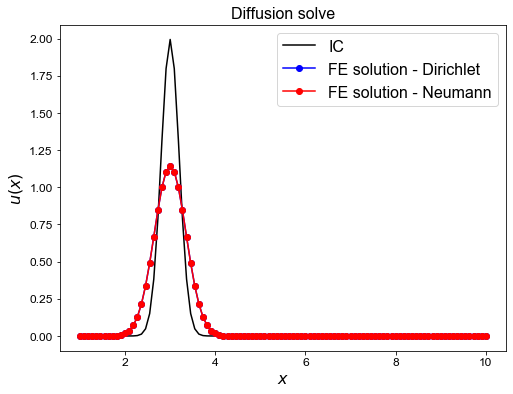

In [32]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u(x)$', fontsize=16)
ax1.set_title('Diffusion solve', fontsize=16)

#ax1.plot(x_nodes, exact_s, 'y-', label='exact)
ax1.plot(x_nodes, u_ic, 'k-', label='IC')
ax1.plot(x_nodes, Dirichlet_solution, 'bo-', label='FE solution - Dirichlet')
ax1.plot(x_nodes, Neumann_solution, 'ro-', label='FE solution - Neumann')
ax1.legend(loc='best', fontsize=16);

use the same function evaluated at the appropriate time as an exact solution to compare our numerical method against. 
For this question you can consider the (non-periodic) domain 𝑥∈[0,3] 

assume homogeneous Neumann boundary conditions. Initialise the problem using the analytical solution centred initially at 𝑥=0.5 
with an initial time for the purposes of evaluating the Gaussian function of 𝑡=0.05. 
Assume a velocity of 1 and a diffusivity of 0.01. Integrate the problem for a total time period of 1 
[NB. I've purposefully set these values and the size of the domain so you don't need to worry about your Gaussian getting close to a boundary].

Perform some experiments with different Δ𝑥 and Δ𝑡 values such that you can demonstrate the expected order of convergence in space and in time (for the time-stepping options of forward Euler, backward Euler and Crank-Nicolson). 
To do this I suggest you fix one of Δ𝑥 or Δ𝑡 and vary the other independently.
